In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import root_mean_squared_error as rmse
import time
import tkinter as tk
from tkinter import messagebox
import math
import matplotlib as mpl
from scipy.spatial import ConvexHull

# our functions
import predict_Beta_I
import choice_start_day
import plot_hyb

import warnings
warnings.filterwarnings(action='ignore')

# to account for updates when files change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df_seeds = pd.read_csv('initial_data/seeds_set_parameters.csv')
df_seeds[df_seeds.set!='test']['seed_number'].values

array([   0,    1,    2, ..., 1497, 1498, 1499])

In [4]:
seed_dirs='initial_data/initial_data_ba_10000/'
seed_number=0
seed_df =  pd.read_csv(seed_dirs+f'seir_seed_{seed_number}.csv')
seed_df = seed_df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()


In [5]:
def apply_methods(seed_dirs='initial_data/initial_data_ba_10000/',
                 idx_s=0, idx_e=11, n_seeds=1201, show_fig_flag=False):
    
    df_seeds = pd.read_csv('initial_data/seeds_set_parameters.csv')
    seed_numbers = df_seeds[df_seeds.set=='test']['seed_number'].values[:n_seeds]

    types_start_day = ['roll_var_npeople']#, 'roll_var', 'roll_var_seq']

    methods = ['last value','rolling mean last value',
               'expanding mean last value','biexponential decay', 

            'median beta', 'regression (day)',

            'median beta;\nshifted forecast',
            'regression (day);\nshifted forecast',
            'regression (day);\nincremental learning',
            'regression (day, SEIR, previous I)','lstm (day, E, previous I)'
              ]

    new_labels = ['last_value', 'rolling_mean_last_value',
            'expanding_mean_last_value','biexponential_decay', 

            'median_beta', 'regression_day',

            'median_beta_shifted_forecast',
            'regression_day_shifted_forecast',
            'regression_day_incremental_learning',
            'regression_day_SEIR_previous_I','lstm_day_E_previous_I'
                 ]

    for type_start_day in types_start_day:

        for beta_pred,new_label in zip(methods[idx_s:idx_e], 
                                       new_labels[idx_s:idx_e]):

            if 'median' in beta_pred:
                model_path = f'{seed_dirs}/median_beta.csv'
            elif 'regression (day)' in beta_pred: 
                model_path = f'{seed_dirs}/regression_day_for_seir.joblib'
            elif '(day, SEIR, previous I)' in beta_pred:
                model_path = f'{seed_dirs}/regression_day_SEIR_prev_I_for_seir.joblib'
            elif 'lstm' in beta_pred:
                model_path = f'{seed_dirs}/lstm_day_E_for_seir'    
            else:
                model_path=''
            print(model_path)
            all_rmse_I, all_rmse_Beta, all_peak, \
                execution_time, start_days = plot_hyb.main_f(I_prediction_method='seir', 
                                    stochastic=False, count_stoch_line=0, 
                                    beta_prediction_method=beta_pred, 
                                    type_start_day=type_start_day, 
                                    seed_numbers=seed_numbers, 
                                    show_fig_flag=show_fig_flag,
                                    seed_dirs=seed_dirs, 
                                    sigma=0.1, gamma=0.08, 
                                    ax=None, model_path=model_path)
            # creating a dataframe for peaks
            all_peak = pd.DataFrame(all_peak, columns=['actual_peak_I', 'predicted_peak_I', 
                                                       'actual_peak_day', 'predicted_peak_day'])
            # creating a dataframe for peaks RMSE, predicted time, start day
            rmse_df = pd.DataFrame({
                'rmse_I': all_rmse_I,
                'rmse_Beta': all_rmse_Beta,
                'time_predict': execution_time,
                f'{type_start_day}': start_days})

            # merging dataframes
            results = pd.concat([rmse_df, all_peak], axis=1)
            
            ntype, npop = seed_dirs[26:-1].split('_')
            if int(npop) == 10000:
                npop = ''
            elif int(npop) == 100000:
                npop = '_100k'
            elif int(npop) == 50000:
                npop = '_50k'

            results.to_csv(f'results/{ntype+npop}/{type_start_day}/{new_label}_results.csv', 
                           index=False)

In [ ]:
def create_boxplots(seed_dirs, type_start_day='roll_var_npeople', n_seeds=301):
    methods = [['$\mathregular{M_{last\_val}}$','$\mathregular{M_{ma\_val}}$',
        '$\mathregular{M_{ca\_val}}$','$\mathregular{M_{biexp}}$'], 

        ['$\mathregular{M_{median}}$','$\mathregular{M_{regr}}$'],

        ['$\mathregular{M^{shift}_{median}}$','$\mathregular{M^{shift}_{regr}}$',
        '$\mathregular{M^{add}_{regr}}$','$\mathregular{M_{reg\_ext}}$',    
        '$\mathregular{M_{LSTM}}$'
        ]]
    new_labels = [['last_value','rolling_mean_last_value',
        'expanding_mean_last_value','biexponential_decay'], 

        ['median_beta','regression_day'],

        ['median_beta_shifted_forecast','regression_day_shifted_forecast',
        'regression_day_incremental_learning','regression_day_SEIR_previous_I',       
        'lstm_day_E_previous_I'
        ]]
    
    switch = type_start_day

    fig = plt.figure(figsize=(12, 4)) 
    gs = gridspec.GridSpec(1, 3, width_ratios=[2,1,2.]) 
    
    ntype, npop = seed_dirs[26:-1].split('_')
    if int(npop) == 10000:
        npop = ''
    elif int(npop) == 100000:
        npop = '_100k'
    elif int(npop) == 50000:
        npop = '_50k'
        
    ax_list = []    
    max_list = []
    for i in range(len(methods)):
        
        rmse_df = pd.DataFrame()
        for beta_prediction_method, new_label in zip(methods[i], new_labels[i]):
            # loading data from CSV
            df = pd.read_csv(f'results/{ntype+npop}/{type_start_day}/{new_label}_results.csv')
            # add data to DataFrame with the column name as the method
            rmse_df[f"{beta_prediction_method}"] = df['rmse_I']
            print(f'Median RMSE I for {new_label}', df['rmse_I'].median())
            
        max_list.append(rmse_df.max().max())
        # creating a boxplot
        ax = plt.subplot(gs[i])
        ax_list.append(ax)
        box = ax.boxplot(rmse_df[methods[i]], showfliers=True, 
                          medianprops=dict(color='red',linewidth=1.5), 
                          widths=0.5, patch_artist=True)
        median_c = (1.0, 0.7, 0.7, 0.2)
        lw=1
        for n, patch in enumerate(box['boxes']):
            if (i == 0) & (n < 3):
                patch.set(facecolor=median_c, linewidth=lw) 
            elif (i == 1) & (n < 1):
                patch.set(facecolor=median_c, linewidth=lw) 
            elif (i == 2) & (n < 3):
                patch.set(facecolor=median_c, linewidth=lw) 
            else:
                patch.set(fill=False)  
        
        ax.set_title(f'RMSE for Infected, group {i+1}')
        if i==1:
            ax.set_xlabel('Methods')
        if i==0:
            ax.set_ylabel('RMSE')
        ax.set_xticks(ticks=np.arange(1, len(methods[i])+1), 
                labels=methods[i], rotation=0, ha='center', fontsize=13)
        ax.grid()  
        
    for ax in ax_list:
        ax.set_ylim(-50, np.max(max_list)*1.1
                   ) 
        
    plt.savefig(f'results/{ntype+npop}/{switch}/rmse_I_3.pdf', 
                format='pdf', bbox_inches='tight')

In [ ]:
apply_methods(seed_dirs='initial_data/initial_data_ba_10000/',
                 idx_s=10, idx_e=11, n_seeds=301, show_fig_flag=False)

initial_data/initial_data_ba_10000//lstm_day_E_for_seir
lstm (day, E, previous I) initial_data/initial_data_ba_10000//lstm_day_E_for_seir
!!  initial_data/initial_data_ba_10000//lstm_day_E_for_seir
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  2
I expect  

In [63]:
apply_methods(seed_dirs='initial_data/initial_data_ba_100000/',
                 idx_s=10, idx_e=11, n_seeds=301, show_fig_flag=False)


last value 

rolling mean last value 

expanding mean last value 

biexponential decay 
initial_data/initial_data_ba_100000//median_beta.csv
median beta initial_data/initial_data_ba_100000//median_beta.csv
initial_data/initial_data_ba_100000//regression_day_for_seir.joblib
regression (day) initial_data/initial_data_ba_100000//regression_day_for_seir.joblib
initial_data/initial_data_ba_100000//median_beta.csv
median beta;
shifted forecast initial_data/initial_data_ba_100000//median_beta.csv
initial_data/initial_data_ba_100000//regression_day_for_seir.joblib
regression (day);
shifted forecast initial_data/initial_data_ba_100000//regression_day_for_seir.joblib
initial_data/initial_data_ba_100000//regression_day_for_seir.joblib
regression (day);
incremental learning initial_data/initial_data_ba_100000//regression_day_for_seir.joblib
initial_data/initial_data_ba_100000//regression_day_SEIR_prev_I_for_seir.joblib
regression (day, SEIR, previous I) initial_data/initial_data_ba_100000//regres

## plot

In [ ]:
create_boxplots(seed_dirs='initial_data/initial_data_ba_10000/', 
                type_start_day='roll_var_npeople', n_seeds=301)

Median RMSE I for last_value 1564.2432793882526
Median RMSE I for rolling_mean_last_value 1789.487733961084
Median RMSE I for expanding_mean_last_value 1463.954824577468
Median RMSE I for biexponential_decay 1885.8141819654047
Median RMSE I for median_beta 290.3779579385052
Median RMSE I for regression_day 524.8670268021787
Median RMSE I for median_beta_shifted_forecast 836.6097298972213
Median RMSE I for regression_day_shifted_forecast 1298.3854285211635
Median RMSE I for regression_day_incremental_learning 502.03164356422417
Median RMSE I for regression_day_SEIR_previous_I 1116.5060679992416


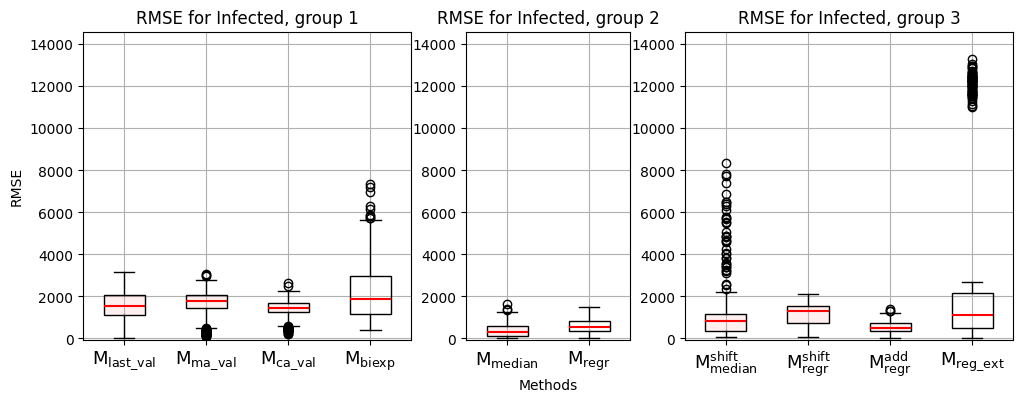

In [66]:
create_boxplots(seed_dirs='initial_data/initial_data_ba_100000/', 
                type_start_day='roll_var_npeople', n_seeds=301)